## SMARTS - Substructure as 2D Strings

SMARTS (SMiles Arbitrary Target Specification) is a convention for specifying molecular substructures. Here we'll
learn the basic principles of SMARTS and see some applications for them.

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw.MolDrawing import DrawingOptions

do = DrawingOptions()
do.bgColor=(17,17,17)

# these options customize how our molecules will look when displayed
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (200,100)
IPythonConsole.ipython_useSVG = True
IPythonConsole.drawOptions.addAtomIndices=False
IPythonConsole.drawOptions.addStereoAnnotation=True
IPythonConsole.drawOptions.baseFontSize=0.7
IPythonConsole.drawOptions.annotationFontScale=1
IPythonConsole.drawOptions.fixedBondLength=20

# these options suppress RDKit errors
from rdkit import RDLogger
rdlogger = RDLogger.logger()
rdlogger.setLevel(RDLogger.CRITICAL)

### Why SMARTS?

SMARTS at first glance seem like a very complicated version of SMILES. However,
there are key capabilities that set them apart. Here I will show a quick
use case.

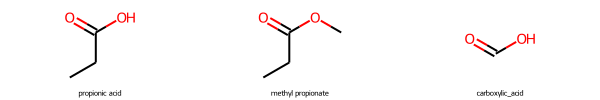

In [2]:
propionic_acid = Chem.MolFromSmiles('CCC(=O)O')
methyl_propionate = Chem.MolFromSmiles('CCC(=O)OC')

# what if we want to find all carboxylic acids in a list of molecules?
# we could try to specify a substructure like this
carboxylic_acid_smiles = 'C(=O)[OH]'
carboxylic_acid_mol = Chem.MolFromSmiles(carboxylic_acid_smiles)

AllChem.Compute2DCoords(carboxylic_acid_mol)
AllChem.GenerateDepictionMatching2DStructure(propionic_acid, carboxylic_acid_mol)
AllChem.GenerateDepictionMatching2DStructure(methyl_propionate, carboxylic_acid_mol)
Chem.Draw.MolsToGridImage(
    mols=[propionic_acid, methyl_propionate, carboxylic_acid_mol],
    legends=['propionic acid', 'methyl propionate', 'carboxylic_acid'],
    molsPerRow=3,
    subImgSize=(200,100),
    useSVG=True,
)

In [3]:
# as expected, propionic acid has a substructure match with our carboxylic acid
print('propionic acid contains carboxylic acid (SMILES): '
      f'{propionic_acid.HasSubstructMatch(carboxylic_acid_mol)}')

# however, methyl propionate does too!
print('methyl propionate contains carboxylic acid (SMILES): '
      f'{methyl_propionate.HasSubstructMatch(carboxylic_acid_mol)}')

propionic acid contains carboxylic acid (SMILES): True
methyl propionate contains carboxylic acid (SMILES): True


As we see, we cannot specify substructures with SMILES as it is not specific enough.
It is not really what SMILES was designed to do. But it is something we can
achieve with SMARTS. For example, we can specify that the acid oxygen MUST have
one hydrogen atom.

propionic acid contains carboxylic acid (SMARTS): True
methyl propionate contains carboxylic acid (SMARTS): False


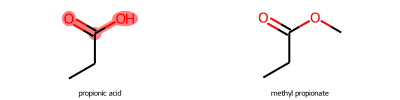

In [4]:
# now instead of SMILES, we use SMARTS
carboxylic_acid_smarts = 'C(=O)[OH1]'
carboxylic_acid_mol = Chem.MolFromSmarts(carboxylic_acid_smarts)

print('propionic acid contains carboxylic acid (SMARTS): '
      f'{propionic_acid.HasSubstructMatch(carboxylic_acid_mol)}')
print('methyl propionate contains carboxylic acid (SMARTS): '
      f'{methyl_propionate.HasSubstructMatch(carboxylic_acid_mol)}')

Chem.Draw.MolsToGridImage(
    mols=[propionic_acid, methyl_propionate],
    legends=['propionic acid', 'methyl propionate'],
    molsPerRow=2,
    subImgSize=(200,100),
    useSVG=True,
    highlightAtomLists=[
          propionic_acid.GetSubstructMatch(carboxylic_acid_mol),
          methyl_propionate.GetSubstructMatch(carboxylic_acid_mol)
    ]
)

### Atoms in SMARTS

In SMILES, we were quite restricted in what atomic properties we could specify.
We could only specify charge, isotope, and number of hydrogens. In SMARTS,
however, the list is much longer:
* aromatic vs aliphatic
* charge
* chirality
* isotope
* degree (# of connections)
* valence (bond order)
* total H count
* ring membership (# of rings the atom is in)
* ring size (size of smallest ring the atom is in)
* wildcard

Here we will just cover the basics but keep in mind that SMARTS are quite
powerful.
<br>
In the previous example, we specified total H count to separate acids from esters.
But with SMARTS, we can do much more.

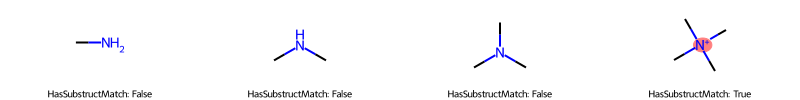

In [5]:
# this SMARTS targets quaternary ammonium salts
# N indicates that it is an aliphatic nitrogen, an aromatic nitrogen would be n
# X4 indicates four connections
# + indicates a positive charge
smarts = '[NX4+]'
substruct = Chem.MolFromSmarts(smarts)
amines = [
    ('primary_amine', Chem.MolFromSmiles('CN')),
    ('secondary_amine', Chem.MolFromSmiles('CNC')),
    ('tertiary_amine', Chem.MolFromSmiles('CN(C)C')),
    ('quaternary_ammonium', Chem.MolFromSmiles('C[N+](C)(C)C')),
]

Chem.Draw.MolsToGridImage(
    mols=[amine[1] for amine in amines],
    legends=[f'HasSubstructMatch: {amine[1].HasSubstructMatch(substruct)}' for amine in amines],
    molsPerRow=4,
    subImgSize=(200,100),
    useSVG=True,
    highlightAtomLists=[amine[1].GetSubstructMatch(substruct) for amine in amines]
)

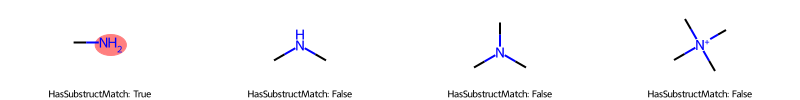

In [6]:
# what about a primary amine?
# here we can specify an aliphatic nitrogen with three connections and two Hs
smarts = '[NX3H2]'
substruct = Chem.MolFromSmarts(smarts)

Chem.Draw.MolsToGridImage(
    mols=[amine[1] for amine in amines],
    legends=[f'HasSubstructMatch: {amine[1].HasSubstructMatch(substruct)}' for amine in amines],
    molsPerRow=4,
    subImgSize=(200,100),
    useSVG=True,
    highlightAtomLists=[amine[1].GetSubstructMatch(substruct) for amine in amines]
)

### Bonds in SMARTS

Bond properties in SMARTS are expanded a lot less compared to atom properties.
However, here are a few new things that can be specified:
* chirality
* bond in ring
* wildcard

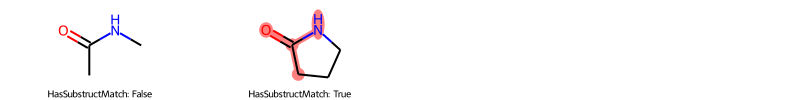

In [7]:
# only specify cyclic amides using @ to indicate bond in ring
smarts = 'C@C(=O)@N'
substruct = Chem.MolFromSmarts(smarts)

amides = [
    ('acyclic_amide', Chem.MolFromSmiles('CC(=O)NC')),
    ('cyclic_amide', Chem.MolFromSmiles('O=C1CCCN1')),
]

amide_core = Chem.MolFromSmiles('C(=O)N')
AllChem.Compute2DCoords(amide_core)
AllChem.GenerateDepictionMatching2DStructure(amides[0][1], amide_core)
AllChem.GenerateDepictionMatching2DStructure(amides[1][1], amide_core)

Chem.Draw.MolsToGridImage(
    mols=[amide[1] for amide in amides],
    legends=[f'HasSubstructMatch: {amide[1].HasSubstructMatch(substruct)}' for amide in amides],
    molsPerRow=4,
    subImgSize=(200,100),
    useSVG=True,
    highlightAtomLists=[amide[1].GetSubstructMatch(substruct) for amide in amides]
)

### Logic and Recursion in SMARTS

The most powerful feature in SMARTS, however, is the use of logic and recursion
to specify a substructure to any arbitrary specificity.

The logical operators are:
* ! meaning NOT
* ; meaning AND
* , meaning OR

A recursive definition is indicated by a $(...) inside a bracket

smarts; [NX3;!$(N=*);!$(N[C,S]=[N,O]);!$(N-C=C);!$(N(c)c)]


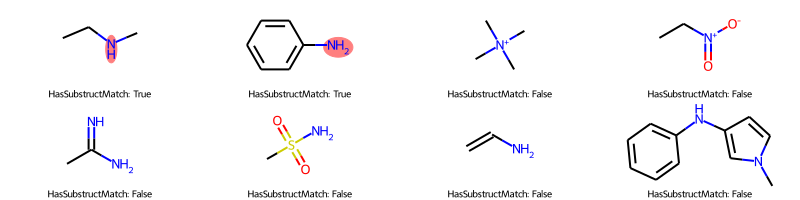

In [8]:
# how could we specify a basic amine?
# we'd need to now think of many common non-basic nitrogen-containing functional
#  groups:
# amides, amidines, enamines, diarylamines, quaternary ammonium, N-oxides, etc.
smarts_components = [
    'NX3',               # exclude quaternary ammoniums
    '!$(N=*)',           # exclude imines, nitro, amidines, etc.
    '!$(N[C,S]=[N,O])',  # exclude amides, amidines, sulfonamide, etc.
    '!$(N-C=C)',         # exclude enamines
    '!$(N(c)c)',         # exclude diarylamines
]
smarts = f'[{";".join(smarts_components)}]'
# smarts = '[NX3;!$(N=*);!$(N[C,S]=[N,O]);!$(N-C=C);!$(N(c)c);!$(Ncn)]'
print(f'smarts; {smarts}')
substruct = Chem.MolFromSmarts(smarts)

n_functional_groups = [
    ('secondary_amine', Chem.MolFromSmiles('CCNC')),
    ('aniline', Chem.MolFromSmiles('Nc1ccccc1')),
    ('quaternary_amine', Chem.MolFromSmiles('C[N+](C)(C)C')),
    ('nitro', Chem.MolFromSmiles('CC[N+]([O-])=O')),
    ('amidine', Chem.MolFromSmiles('NC(=N)C')),
    ('sulfonamide', Chem.MolFromSmiles('CS(=O)(=O)N')),
    ('enamine', Chem.MolFromSmiles('N-C=C')),
    ('diarylamine', Chem.MolFromSmiles('c1ccccc1Nc2ccn(C)c2')),
]

Chem.Draw.MolsToGridImage(
    mols=[n_functional_group[1] for n_functional_group in n_functional_groups],
    legends=[f'HasSubstructMatch: {n_functional_group[1].HasSubstructMatch(substruct)}' for n_functional_group in n_functional_groups],
    molsPerRow=4,
    subImgSize=(200,100),
    useSVG=True,
    highlightAtomLists=[n_functional_group[1].GetSubstructMatch(substruct) for n_functional_group in n_functional_groups]
)

Here ends our introduction to SMARTS strings! I find best way to learn SMARTS
is to practice with it so you should sit down and try to specify your favorite
functional groups using SMARTS.
The syntax is admittedly a little difficult at first but it will get easier with practice. 

Lastly, I highly recommend https://smarts.plus as an awesome tool for
visualizing and double checking SMARTS definitions. While the best tool for
checking SMARTS definitions is writing lots of test cases, smarts.plus is nice
for rapid iterations of ideas.